## Evaluate YAMNET

#### Setup

In [48]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
os.sys.path.append('./audioset/yamnet')
import params
from datagen_yamnet import DataGenerator, get_files_and_labels

model = tf.keras.models.load_model("I:/model/vehicle/v1/saved_model/model.h5")
test_dir = "I:/datasets/vehicle/dataset/v1_spectrograms/test_set/"

#### Get test data files and labels

In [49]:
files_test, labels_test, _, _, class_dict = get_files_and_labels(test_dir, typ='npy', train_split=1)
print(labels_test)
class_dict_rev = {(str(v)): k for k, v in class_dict.items()}

{'environment': 0, 'vehicle': 1}


In [50]:
batch_size = 1

test_generator = DataGenerator(files_test,
                                labels_test,
                                shuffle=False,
                                batch_size=batch_size)

#### Evaluate

In [51]:
evaluate = model.evaluate(test_generator, verbose=1)
print("Evaluate value:", evaluate)

3671/3671 [==============================] - 16s 4ms/step - loss: 0.1504
Evaluate value: 0.15037120878696442


#### Predict

In [52]:
predict = model.predict(test_generator, verbose=1)
print("Predict value:", predict)

3671/3671 [==============================] - 13s 4ms/step
Predict value: [[9.99990940e-01 9.01666863e-06]
 [9.99884486e-01 1.15550196e-04]
 [9.99995351e-01 4.63723654e-06]
 ...
 [3.24266069e-02 9.67573404e-01]
 [6.87209103e-05 9.99931216e-01]
 [5.80611825e-02 9.41938877e-01]]


#### AUC

In [54]:
y_true = []
for i, ID in enumerate(test_generator.list_IDs):
    class_id = ID.split('/')[-2]
    y_true.append(class_dict_rev.get(class_id))
y_true = np.array(y_true)
y_pred_score = np.array(predict[:,1])

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_score)
auc_value = metrics.auc(fpr, tpr)
print(f"AUC: {auc_value}")
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]
print(f"Best Threshold={best_threshold}, G-Mean={gmeans[ix]}")

AUC: 0.9860591497754295
Best Threshold=0.2884048521518707, G-Mean=0.9460647539663729


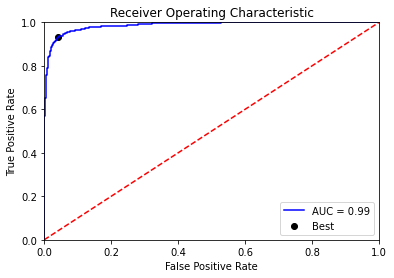

In [55]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_value)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('yamnet_augmented_roc.png')
plt.show()

#### Precision and Recall Curve

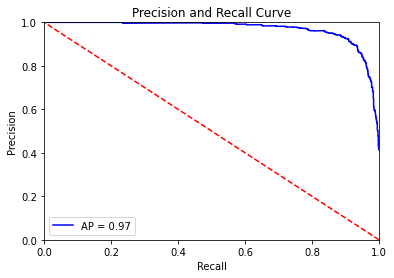

In [56]:
avg_precision_score = metrics.average_precision_score(y_true, y_pred_score)

precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred_score)

plt.title('Precision and Recall Curve')
plt.plot(recall, precision, 'b', label = 'AP = %0.2f' % avg_precision_score)
plt.legend(loc = 'lower left')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('yamnet_augmented_prec.png')
plt.show()

#### Calcurate confusion metrix

In [57]:
# y_pred = np.argmax(predict, axis=1)

y_pred = []

for y in y_pred_score:
    if (y < best_threshold):
        y_pred.append(0)
    else:
        y_pred.append(1)
        
cfmx = metrics.confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cfmx)

tn, fp, fn, tp = cfmx.ravel()
print(f"true positive: {tp}, true negative: {tn}, false positive: {fp}, false negative: {fn}")

Confusion matrix:
[[2563  111]
 [  66  931]]
true positive: 931, true negative: 2563, false positive: 111, false negative: 66


In [58]:
report = metrics.classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2674
           1       0.89      0.93      0.91       997

    accuracy                           0.95      3671
   macro avg       0.93      0.95      0.94      3671
weighted avg       0.95      0.95      0.95      3671

